In [1]:
import torch
import random
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader

corpus_file = '../hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file, 'r', encoding='utf-8') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 55      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
two_hint_ratio = 0.0

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    addition_tokens = []
    
    hint_word = 2 if random.random() < two_hint_ratio else 1

    selected_idice = random.sample(list(range(min(n,embedder.maxPOS))), k=min(n,hint_word))
    
    for selected_idx in selected_idice:
        
        addition_tokens.append(str(selected_idx+1))
        addition_tokens.append(latter[selected_idx])
    
    former = ['<SOS>'] + former + ['<EOS>'] + addition_tokens
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    
    all_set.append((former,latter))

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
# list of turple : [(x0,y0),(x1,y1),(x2,y2),....]
all_set[5]

(['<SOS>',
  '你',
  '最',
  '想',
  '去',
  '的',
  '目',
  '的',
  '地',
  '剩',
  '多',
  '少',
  '公',
  '里',
  '<EOS>',
  '8',
  '可'],
 ['<SOS>', '累', '了', '也', '没', '关', '系', '我', '可', '以', '暂', '停', '<EOS>'])

In [9]:

class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            for i in range(data.index('<EOS>')+1,len(data),2):
                
                idx = int(data[i])
                focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [10]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence length:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence length: tensor([ 9, 12, 19, 14]) [7, 10, 12, 9] 

['<SOS>', '找', '不', '到', '人', '懂', '<EOS>', '1', '怕', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '怕', '黑', '的', '折', '磨', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '怕', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '一', '直', '喜', '欢', '你', '的', '热', '络', '<EOS>', '6', '的', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '一', '直', '喜', '欢', '你', '的', '轻', '松', '<EOS>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '的', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>'] 

['<SOS>', '让', '他', '欣', '赏', '我', '深', '呼', '吸', '我', '自', '然', '美', '的', '姿', '彩', '<EOS>', '4', '每']
['<SOS>', '爱', '世', '间', '每', '种', '温', '暖', '的', '色', '彩', '<EOS>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '每', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>'] 

['<SO

In [11]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False)

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [12]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [14]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6618, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6618, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6618, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training ( Dont run when analysing )

In [15]:
# def run_epoch(epoch,dataset,isTraining):
    
#     if isTraining:
#         model.train()
#     else:
#         model.eval()
        
#     dataloader = DataLoader(dataset=dataset,
#                             batch_size=32,
#                             shuffle=True,
#                             collate_fn=dataset.collate_fn,
#                             num_workers=0)
    
#     if isTraining:
#         desc='Train {}'
#     else:
#         desc='Valid {}'
    
#     trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
#     loss=0
#     acc = 0
    
#     for i,(x,x_len,y,y_len,y_) in trange:
        
#         x = x.to(device)
#         y = y.to(device)
#         y_ = y_.to(device)
        
#         # outputs : [b,emb,s] , hiddens : [b,s,hidden]
#         outputs,hiddens = model(x,x_len,y,y_len)
        
#         idx = y_>2
#         tf_map = y_[idx] == outputs.argmax(1)[idx]
#         batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
#         acc += batch_acc
        
#         batch_loss_all = criterion(outputs, y)
#         batch_loss_designated = criterion(outputs, y_)
#         batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
#         if isTraining:
#             optimizer.zero_grad()
#             batch_loss.backward()
#             optimizer.step()
        
#         loss += batch_loss.item()
        
#         trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
#         if isTraining:
#             history_loss['train'].append(batch_loss.item())
#             history_acc['train'].append(batch_acc)
#         else:
#             history_loss['valid'].append(batch_loss.item())
#             history_acc['valid'].append(batch_acc)

In [16]:
# # Training

# dataset_all = SentDataset(all_set)
# dataset_train = SentDataset(train_set)
# dataset_valid = SentDataset(valid_set)

# criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# max_epoch = 20
# focus_ratio = 0.5

# history_loss = {'train':[],'valid':[]}
# history_acc = {'train':[],'valid':[]}


# for epoch in range(max_epoch):
    
#     # Training
#     run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
#     # Validation
#     run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
#     # Saving
#     if not os.path.exists('model'):
#         os.makedirs('model')
#     torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))

# Plot (Loss and acc)  ( Dont run when analysis )

In [17]:
# import matplotlib.pyplot as plt

# modes = ['train', 'valid']
# recs = [history_loss, history_acc]
# names = ['Loss', 'Accuracy']

# values = []
# for mode in modes:
#     v = []
#     for rec in recs:
#         v.append(rec[mode])
#     values.append(v)

# plt.figure(figsize=(32, 4))
# plt.subplots_adjust(left=0.02, right=0.999)
# for r, name in enumerate(names):
#     plt.subplot(1, len(recs), r+1)
#     for m in range(len(modes)):
#         plt.plot(values[m][r])
#     plt.title(name)
#     plt.legend(modes)
#     plt.xlabel('iteration')
#     plt.show()
# #plt.savefig('figure.png', dpi=100)

## Convert models into directly-pickled format to solve cross-platform inconsistency

In [18]:
# import pickle

# path = 'pre-train/model.pkl.2-1-1'
# with open(path+'.state_dict', 'wb') as f:
#     pickle.dump(model.cpu().state_dict(), f)

# Inference Test Data

## Define test data dataloader

In [19]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [20]:
path_pkl = '../pre-train/model.pkl.2-1-1'
directly_pickled_format = True

if directly_pickled_format:
    import pickle
    with open(path_pkl+'.state_dict', 'rb') as f:
        state_dict = pickle.load(f)
    for par_name in list(state_dict):
        path = par_name.split('.')
        obj = model
        for attr in path[:-1]:
            obj = getattr(obj, attr)
        setattr(obj, path[-1], torch.nn.Parameter(state_dict[par_name]))
    model.to(device)
else:
    model.load_state_dict(torch.load(path_pkl, map_location=device))
    model.decoder.teacher_forcing_ratio = 0.0
    model.eval()

## Weight analysis

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

dist_measure = {
    'Euc': lambda x1, x2: np.linalg.norm(x1-x2),
    'cos': lambda x1, x2: np.linalg.norm(x1/np.linalg.norm(x1) - x2/np.linalg.norm(x2))**2,
}

def reorder(dist_matrix):
    # order the groups so that similar groups are close in the list
    dist = np.copy(dist_matrix)
    n = len(dist)
    mask = np.zeros((n,))
    mask_val = np.max(dist)+1.0

    # ignore the distences on diagonal
    for i in range(n):
        dist[i,i] = np.Inf
        
    draw = np.argmin(np.min(dist, axis=0))
    indices = [draw]
    mask[draw] = mask_val
    for i in range(n-1):
        draw = np.argmin(dist_matrix[draw]+mask)
        indices.append(draw)
        mask[draw] = mask_val
    return indices

def cluster(point_list, n_cluster, dist='Euc'):
    '''
    Use k-means to find cells with similar trend.
    The returned lists are ordered so that similar groups are close.
    
    :param ndarray(float) point_list: Shape = (n_point, n_feature)]
    :param int n_cluster: For k-means
    :return tuple(list, list): reordered groups and centers:
        groups: list(list(int))
        centers: list(ndarray(shape=(n_feature,)))
    '''
    # k-means
    kmeans = KMeans(n_cluster, random_state=0, n_jobs=-1).fit(point_list)
    dist_s2c = kmeans.inertia_/len(point_list)
    print('average of squared distances of samples to centers:', dist_s2c)
    centers = kmeans.cluster_centers_
    m_pairs_squared = ((centers[None, :, :] - centers[:, None, :])**2)
    dist_c2c = m_pairs_squared.sum() / (n_cluster*(n_cluster-1))
    print('average of squared distances of centers to centers:', dist_c2c)
    print('ratio:', dist_c2c/dist_s2c)
    
    # calculate distances
    dist = dist_measure[dist]
    dist_matrix = np.zeros((n_cluster, n_cluster))
    for i in range(n_cluster):
        for j in range(n_cluster):
            dist_matrix[i,j] = dist(centers[i], centers[j])
    
    # reorder the groups
    group_idx = reorder(dist_matrix)
    
    # collect groups
    groups = []
    for i in range(n_cluster):
        groups.append([])
    for i, l in enumerate(kmeans.labels_):
        groups[l].append(i)
        
    # reorder the cells in each group
    for n in range(n_cluster):
        g = groups[n]
        n_local = len(g)
        dist_local = np.zeros((n_local, n_local))
        for i in range(n_local):
            for j in range(n_local):
                dist_local[i,j] = dist(point_list[g[i]], point_list[g[j]])
        indices = reorder(dist_local)
        groups[n] = [g[i] for i in indices]
    
    reordered_groups = []
    reordered_centers = []
    for i in group_idx:
        reordered_groups.append(groups[i])
        reordered_centers.append(centers[i])
    return reordered_groups, reordered_centers

def plot_weights(W, groups=None):
    # concatenate groups and reorder cells
    if groups:
        indices = []
        seps = [] # seperations
        ticks, xlabels, ylabels = [], [], []
        accu = 0
        for g, group in enumerate(groups):
            indices += group
            accu += len(group)
            seps.append(accu)
            ticks.append(accu-len(group)/2)
            xlabels.append(len(group))
            ylabels.append(str(g))
        seps = seps[:-1]
        W = W[:,indices]
        
    # plot
    fig, ax = plt.subplots(figsize=(15,15))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    
    vmax = np.max(np.abs(W))
    plt.imshow(W, cmap='bwr', vmax=vmax, vmin=-vmax)
    plt.colorbar().ax.tick_params(labelsize=24)
    
    if groups:
        for sep in seps:
            plt.axvline(x=sep-0.5,color='black', lw=0.5)
            plt.axhline(y=sep-0.5,color='black', linewidth=0.5)
        plt.xticks(ticks, xlabels, fontsize=24)
        plt.yticks(ticks, ylabels, fontsize=24)
        plt.xlabel('Group size', fontsize=24)
        plt.ylabel('Group ID', fontsize=24)
        
    plt.savefig('weight_.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

def analyze_weights(W, n_cluster=15, dist='cos'):
    groups, centers = cluster(W.transpose(), n_cluster, dist) # use dim0 of W as features
    plot_weights(W, groups)
    return groups

In [22]:
W_hh = model.decoder.cell.weight_hh.detach().numpy()
W_hr, W_hz, W_hn = W_hh[0:128], W_hh[128:256], W_hh[256:384]

In [23]:
print('ratio of power on diagonal:')
weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
for name, W in weights.items():
    print(name+'\t', (np.linalg.norm(np.multiply(W, np.eye(128)), ord='fro') / np.linalg.norm(W, ord='fro'))**2)

ratio of power on diagonal:
reset	 0.025926014933108265
input	 0.06055637411472131
new	 0.02795426802714997


average of squared distances of samples to centers: 16.23127987850306
average of squared distances of centers to centers: 53.07252720424107
ratio: 3.269768471833887


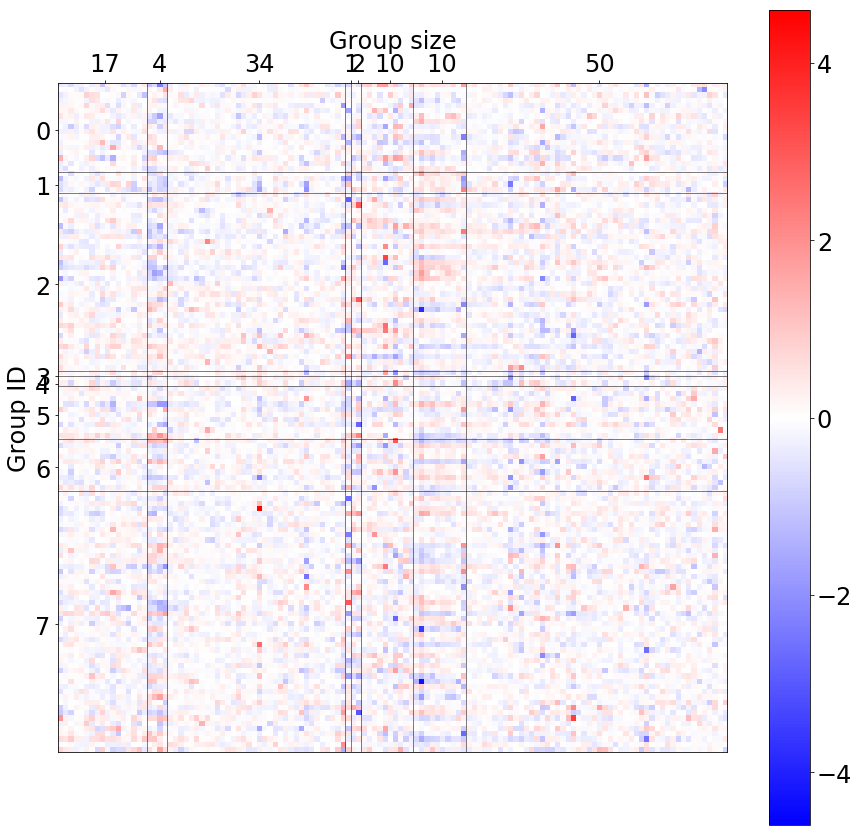

In [24]:
groups = analyze_weights(W_hn, 8)

In [25]:
for g, group in enumerate(groups):
    print(f'{g}:\t{group}')

0:	[43, 83, 89, 84, 64, 116, 110, 90, 11, 125, 55, 46, 2, 127, 67, 72, 108]
1:	[3, 117, 104, 114]
2:	[38, 76, 113, 91, 28, 68, 122, 30, 1, 42, 52, 88, 85, 77, 56, 26, 107, 80, 14, 51, 57, 115, 62, 12, 120, 45, 87, 48, 118, 21, 8, 121, 124, 126]
3:	[58]
4:	[23, 78]
5:	[47, 109, 86, 33, 95, 74, 103, 10, 94, 4]
6:	[24, 36, 59, 82, 73, 53, 6, 39, 97, 44]
7:	[0, 37, 35, 92, 65, 99, 93, 7, 9, 54, 18, 22, 27, 79, 16, 102, 105, 25, 20, 17, 106, 41, 112, 32, 40, 34, 61, 69, 5, 111, 29, 15, 75, 31, 49, 123, 13, 98, 81, 96, 19, 63, 101, 60, 50, 100, 119, 70, 66, 71]


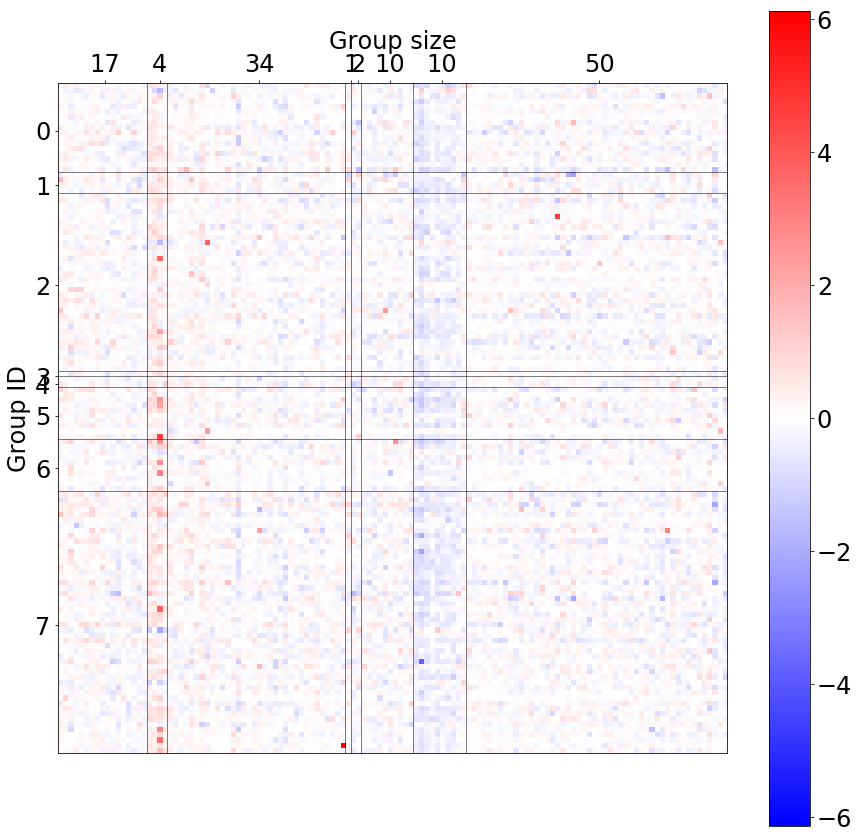

In [26]:
plot_weights(W_hz, groups)

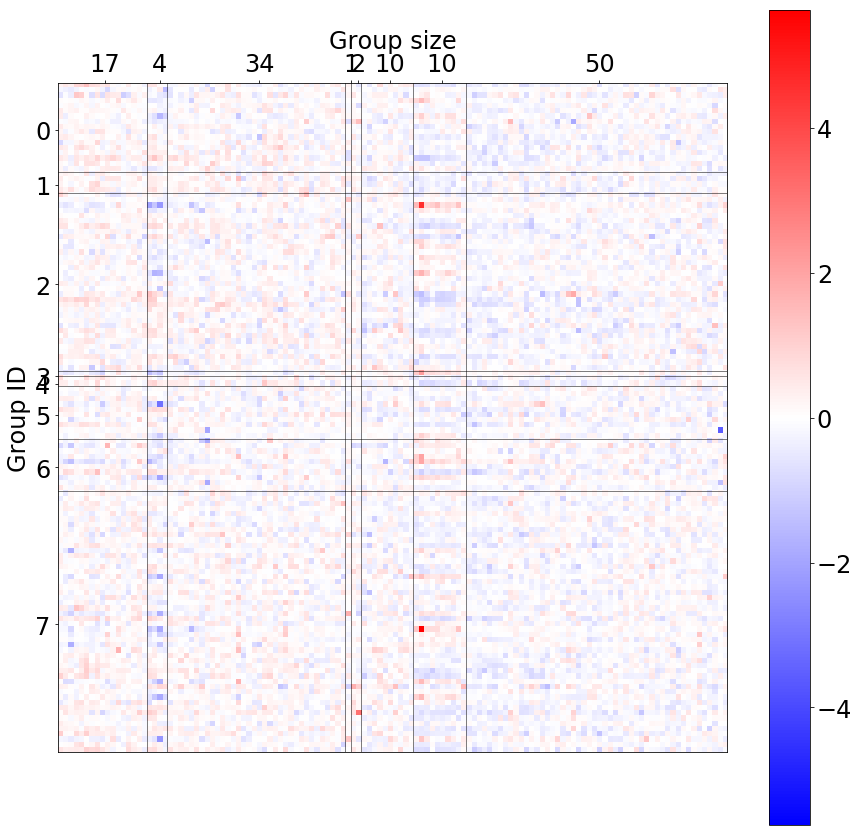

In [27]:
plot_weights(W_hr, groups)

## Implement GRU Cell to collect cell states while inferencing

In [28]:
import torch.nn.functional as F

def Deconstruction(model,x,x_len):
    
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    for iteration in range(15):
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        new_gate = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        # mask specific cells
        mask = torch.ones(128)
        for cell in disabled_cells:
            mask[cell] = 0
        decoder_hidden *= mask
        
        # save states
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = {
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2)            # (b,128,s)
    }
    
    return outputs, gru_info

## Generate certain condition valid datas ( by designated word / position filter )

In [29]:
def get_certain_set(pos, word, show=False):
    certain_set = []

    designated_POS = pos
    designated_word = word

    for sent in random.sample(corpus, k=128):

        control_signal = [str(designated_POS) , designated_word]

        data = ['<SOS>'] + sent + ['<EOS>'] + control_signal

        if show:
            print(data)

        certain_set.append(data)

    dataset_certain = TestDataset(certain_set)
    return dataset_certain

## Prediction certain condition data

In [30]:
def predict(dataset):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=128,
                            shuffle=False,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)

    predictions = []
    trange = tqdm(dataloader, total=len(dataloader))

    for x,x_len in trange:

        x = x.to(device)

        outputs, gru_info = Deconstruction(model,x,x_len)

        for pred in outputs.cpu().detach().numpy().argmax(1):
            predictions.append(pred)
    return predictions, gru_info

In [31]:
def untokenize_output(dataset, predictions):
    # Process multi-EOS tokens
    predictions_set = []
    for p in predictions:
        p = list(p)
        if EOS in p:
            p = p[:p.index(EOS)+1]
        else:
            p.append(EOS)
        predictions_set.append(embedder.unTokenize(p))

    for sent_id in range(len(dataset)):
        sent_in = ''.join(dataset[sent_id])
        sent_pred = ''.join(predictions_set[sent_id])
        print(f'input:\t{sent_in}\npred:\t{sent_pred}\n')

## Cell classification

In [32]:
def plot_cells(cells, include='all', exclude=None, show_legend = False, ylim=(0, 1)):
    '''
    Plot line chart of cells in the set "include - exclude".
    
    :param ndarray(float) cells: Shape = (128, s)
    :param set(int) inlcude: Indices of "cells"
    :param set(int) exclude: Indices of "cells"
    :param bool show_legend: For plotting
    :param tuple(float) ylim: For plotting
    '''
    if include=='all':
        include = set(range(cells.shape[0]))
    picked = include-exclude if exclude else include
    print('cells:', sorted(list(picked)))
    
    x = np.arange(output_len)
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.xlim((0, output_len))
    plt.ylim(ylim)
    for i, cell in enumerate(cells):
        if i in picked:
            plt.plot(x, cell, label=f'cell {i}')
    if show_legend:
        leg = ax.legend(loc='upper right', shadow=True)
    plt.title(f'{len(picked)} cells')
    plt.show()
    
def hist_cells(diff, max_diff):
    '''
    Plot histogram of "diff".
    
    :param array(float) diff: Shape = (n_cells, )
    :param float max_diff: For plotting
    '''
    fig, ax = plt.subplots(figsize=(16, 3))
    n, bins, patches = plt.hist(diff, bins=20, range=(0, max_diff))
    ax.set_xticks(bins)
    for i in range(len(n)):
        plt.text(bins[i], n[i], str(n[i]))

def get_set(cells, feature, mask=None, criterion=lambda d: True, max_diff=0.5, include='all'):
    '''
    get the set of cells close to "feature" and satisfying "criterion" weighted by "mask".
    :param ndarray(float) cells: Shape = (128, s)
    :param array(float) feature: Shape = (s, )
    :param array(float) mask: Shape = (s, )
    :param lambda float->bool criterion: Reture True if diff is in the desired range
    :return set(int): picked indices
    '''
    feature = np.array(feature)
    mask = np.ones(cells.shape[1]) if mask==None else np.array(mask)
    
    if include=='all':
        include = set(range(cells.shape[0]))
    
    diffs = np.zeros(cells.shape[0])
    picked = set()
    for i, cell in enumerate(cells):
        diffs[i] = np.sqrt(np.sum(np.square(cell-feature)*mask)/np.sum(mask))
        if (i in include) and criterion(diffs[i]):
            picked.add(i)
    others = set(range(len(cells))) - picked
    
    hist_cells([diffs[i] for i in picked], max_diff)
    plt.title(f'picked: {len(picked)}')
    hist_cells([diffs[i] for i in others], max_diff)
    plt.title(f'others: {len(others)}')
    plot_cells(cells, include=picked, show_legend=True)
    return picked

def analyze_cells(cells, n_cluster, ylim=(0, 1)):
    '''
    plot all groups in "cells"
    
    :param ndarray(float) cells: Shape = (128, s)
    :param int n_cluster: For k-means
    :param tuple(float) ylim: For plotting
    '''
    groups, centers = cluster(cells, n_cluster)
    for i, group in enumerate(groups):
        print('-----------------------------')
        print(f'group {i}: {centers[i]}')
        plot_cells(cells, include=group, show_legend=True, ylim=ylim)

def draw(string):
    import random
    idx = random.randrange(len(string))
    print(string[idx])
    return string[idx]

In [33]:
# disabled_cells = {*(groups[7][:20])}
disabled_cells = {}

In [34]:
# certain_set = get_certain_set(8, draw('张朦胧的话只是无聊的暗号'))
certain_set = get_certain_set(5, '女')

In [35]:
import numpy as np

predictions, gru_info = predict(certain_set)

gates = {'input': gru_info['updategates'].detach().cpu().numpy(),
         'reset': gru_info['resetgates'].detach().cpu().numpy(),
         'new': gru_info['newgates'].detach().cpu().numpy(),
         'hidden': gru_info['hiddens'].detach().cpu().numpy()} # (b,128,s)

gates_avg = {}
gates_std = {}
for key, value in gates.items():
    gates_avg[key] = value.mean(0) # (128,s)
    gates_std[key] = value.std(0) # (128,s)

output_len = gates['input'].shape[2]
print(output_len)


7


In [36]:
untokenize_output(certain_set, predictions)

input:	<SOS>我的心没有回程<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>我们都是浴火的凤凰<EOS>5女
pred:	<SOS>我的的的女<EOS>

input:	<SOS>所有孤独不再<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>不知道愁就知道乐<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>注定似过路人陌生你怎么手震<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>击鼓扬帆风正好梦在不远处<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>这感情的无奈<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>这家伙真太可恶了<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>你為我彈奏最美的音樂<EOS>5女
pred:	<SOS>我是我小女<EOS>

input:	<SOS>一早一晚愿望递减困进五指山年月是有限<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>一个叫做命运的茫茫旅途<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>流浪时光乐仔<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>就这样睡了过去再也没有醒来<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>把爱剪碎了随风吹向大海<EOS>5女
pred:	<SOS>我的的的女<EOS>

input:	<SOS>明天的故事开始等待新的未来<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>好<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>你来到寒冷的地方<EOS>5女
pred:	<SOS>我的的的女<EOS>

input:	<SOS>爱到亲爱的你敢炫耀<EOS>5女
pred:	<SOS>我是的的女<EOS>

input:	<SOS>哦妈妈哦妈妈<EOS>5女
pred:	<SOS>我们的的女<EOS>

input:	<

input--------------------
cells: [3, 104, 114, 117]


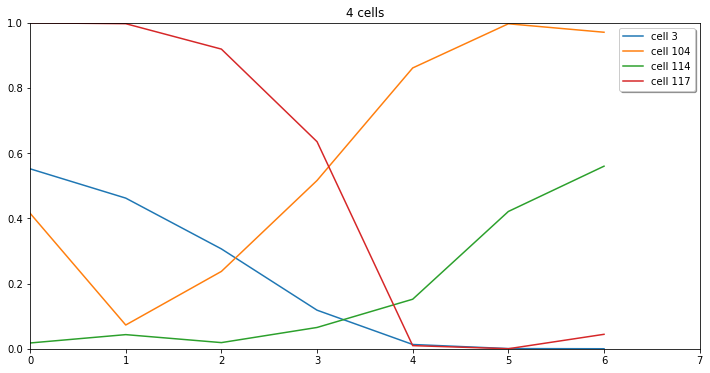

cells: [3, 104, 114, 117]


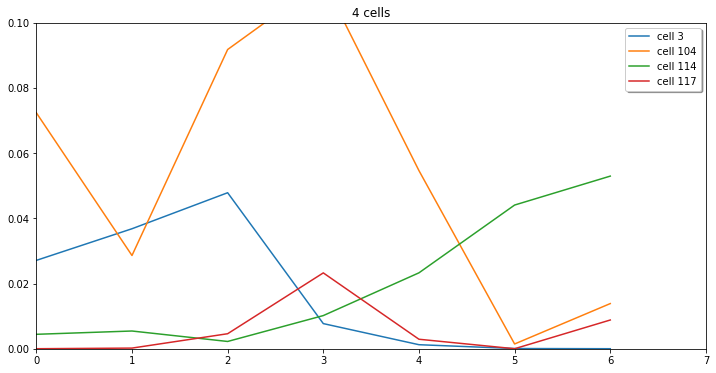

new--------------------
cells: [3, 104, 114, 117]


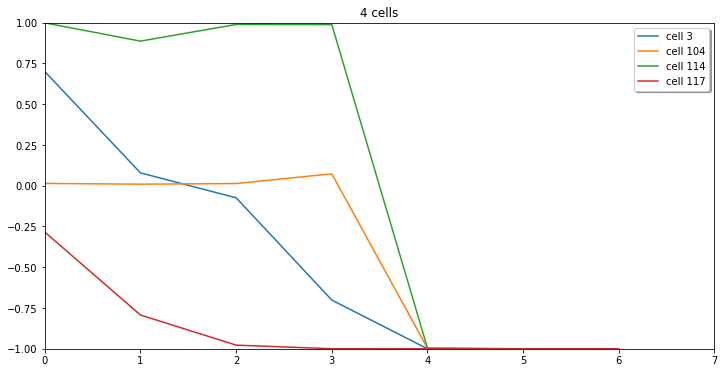

cells: [3, 104, 114, 117]


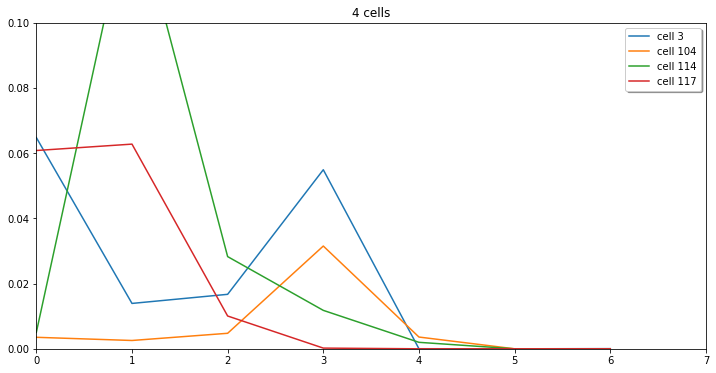

reset--------------------
cells: [3, 104, 114, 117]


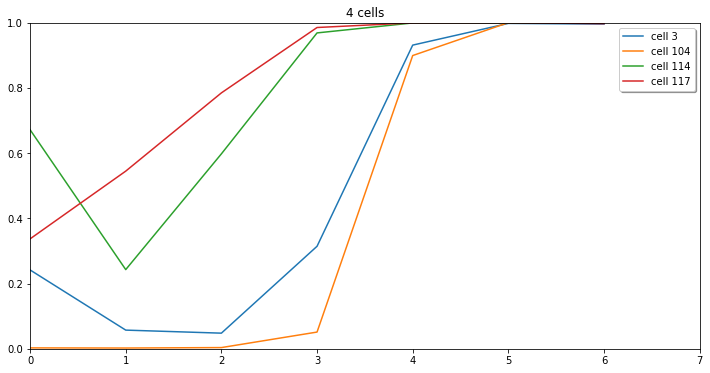

cells: [3, 104, 114, 117]


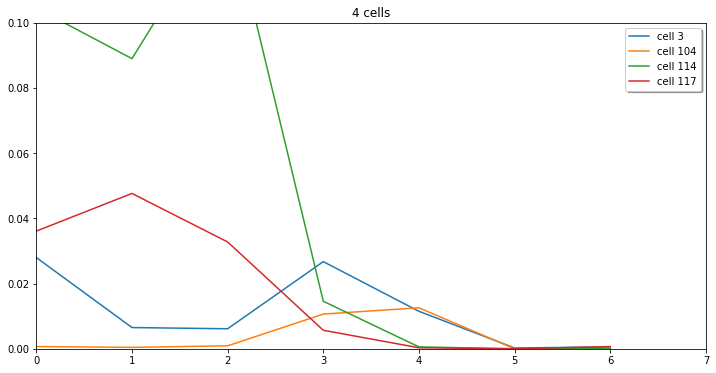

hidden--------------------
cells: [3, 104, 114, 117]


cells: [3, 104, 114, 117]


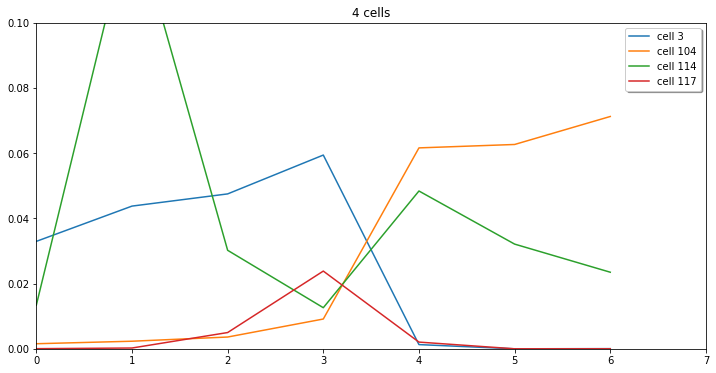

In [37]:
n = 1
print('input--------------------')
plot_cells(gates_avg['input'], include=groups[n], show_legend=True)
plot_cells(gates_std['input'], include=groups[n], show_legend=True, ylim=(0,0.1))
print('new--------------------')
plot_cells(gates_avg['new'], include=groups[n], show_legend=True, ylim=(-1,1))
plot_cells(gates_std['new'], include=groups[n], show_legend=True, ylim=(0,0.1))
print('reset--------------------')
plot_cells(gates_avg['reset'], include=groups[n], show_legend=True)
plot_cells(gates_std['reset'], include=groups[n], show_legend=True, ylim=(0,0.1))
print('hidden--------------------')
plot_cells(gates_avg['hidden'], include=groups[n], show_legend=True, ylim=(-1,1))
plot_cells(gates_std['hidden'], include=groups[n], show_legend=True, ylim=(0,0.1))

types: {
}
cells: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


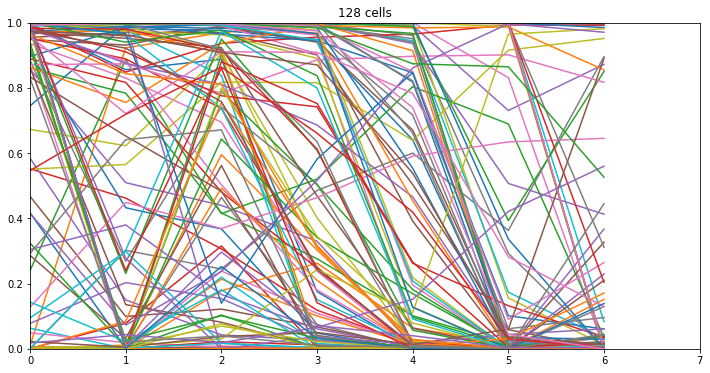

In [38]:
cell_types = {
#     'EOS': {9, 44, 49, 58, 78, 87, 106},
#     'designated': {10, 15, 19, 47, 57, 60, 62, 82},
#     'large': {35, 36, 104},
#     'test': {4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116},
}

# cell_types['xxx10'] = picked

included = set(range(len(gates_avg['input'])))
print('types: {')
for key, value in cell_types.items():
    print(f"'{key}': {value},")
    included -= value
print('}')
plot_cells(gates_avg['input'], include=included)

In [39]:
sem = {9, 16, 44, 49, 50, 58, 70, 77, 78, 80, 87, 95, 96, 103, 106, 126}
g7 = set(groups[7])
len(sem), len(sem-g7)

(16, 9)

In [40]:
for key, value in cell_types.items():
    print(f'{key}:----------------------')
    plot_cells(gates_avg['input'], include=value, show_legend=True)
    plot_cells(gates_std['input'], include=value, show_legend=True, ylim=(0,0.1))

cells: [9, 16, 44, 49, 58, 78, 87, 95, 103, 106, 122]


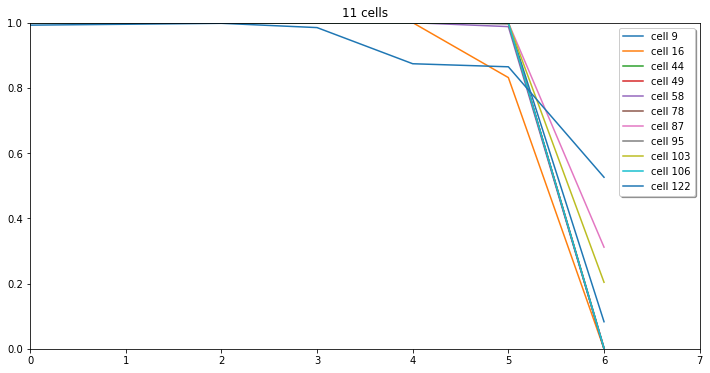

In [41]:
picked = get_set(gates_avg['input'],
    [1,1,1,1,1,1,0],
    [1,1,1,1,1,3,3],
    lambda d: d<0.3,# and d>0.3,
    max_diff=0.9,
#     include=included,
)

average of squared distances of samples to centers: 0.07345961533437909
average of squared distances of centers to centers: 2.3082025437127975
ratio: 31.421380757388192
-----------------------------
group 0: [0.95051825 0.8916663  0.8013384  0.23029855 0.01527891 0.00190583
 0.00835742]
cells: [0, 6, 8, 28, 33, 39, 41, 45, 46, 59, 115, 121]


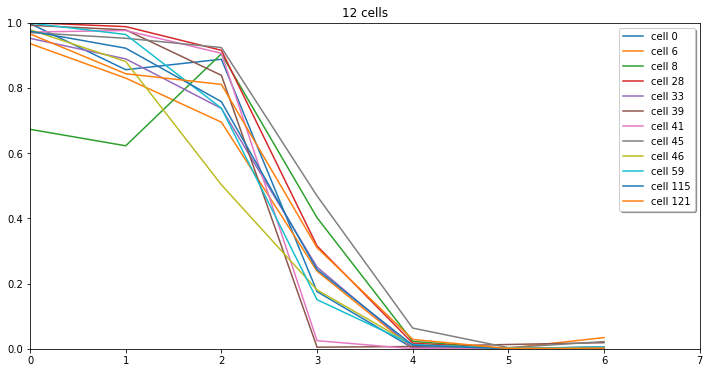

-----------------------------
group 1: [0.7740171  0.6620678  0.39564487 0.13736042 0.0170221  0.00261341
 0.07351246]
cells: [3, 14, 20, 22, 53, 64, 75, 107]


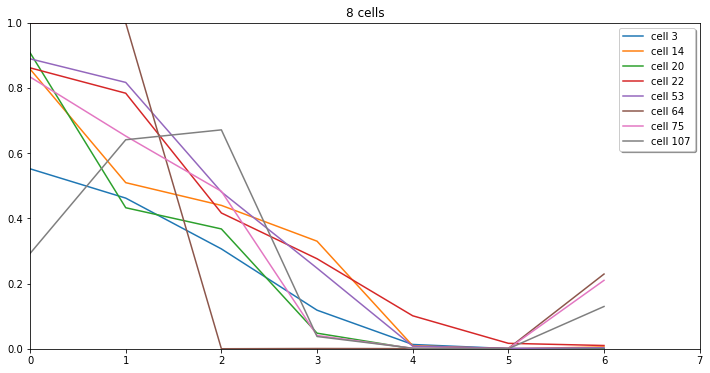

-----------------------------
group 2: [0.9167029  0.05253017 0.11703855 0.05092731 0.01317888 0.00544673
 0.06227966]
cells: [2, 21, 26, 34, 65, 84, 102, 108, 112, 120, 124, 127]


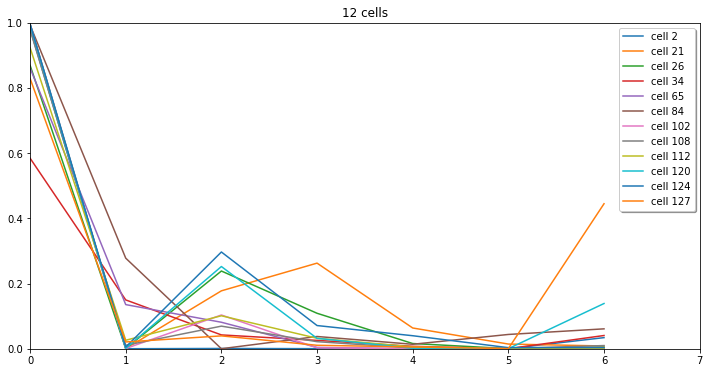

-----------------------------
group 3: [0.95547074 0.10861969 0.8462262  0.407943   0.0859887  0.00175159
 0.00298357]
cells: [12, 37, 42, 52, 88, 93, 113]


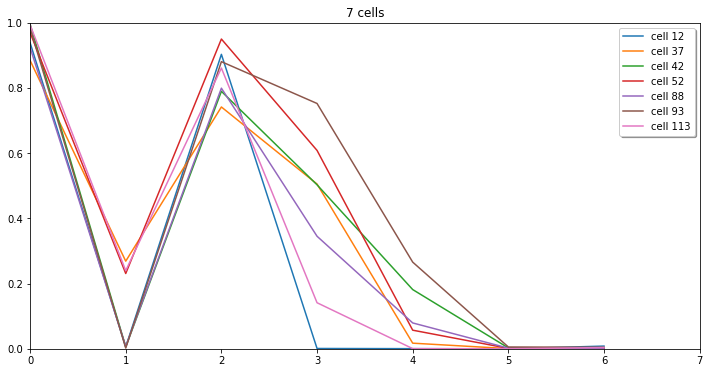

-----------------------------
group 4: [0.08748925 0.06272942 0.6407918  0.29281056 0.04455006 0.00084025
 0.00946359]
cells: [11, 27, 55, 61, 72, 101, 119]


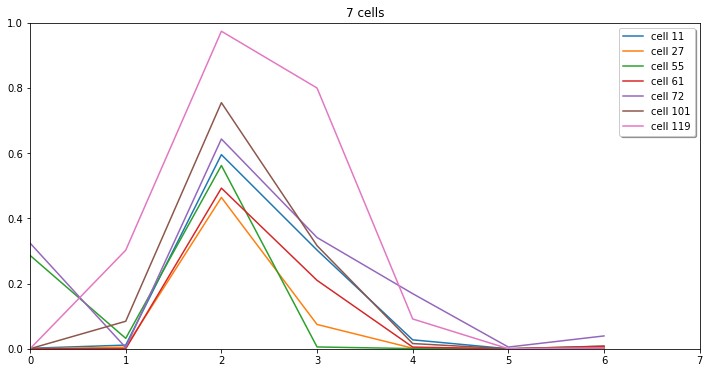

-----------------------------
group 5: [0.06785506 0.05055088 0.07779425 0.01363641 0.00236827 0.00213937
 0.02685536]
cells: [13, 23, 29, 31, 40, 56, 63, 69, 71, 79, 85, 94, 99, 109, 111, 118]


-----------------------------
group 6: [0.14624399 0.08769691 0.08298433 0.05194497 0.04340467 0.12133187
 0.5362109 ]
cells: [35, 54, 105, 114]


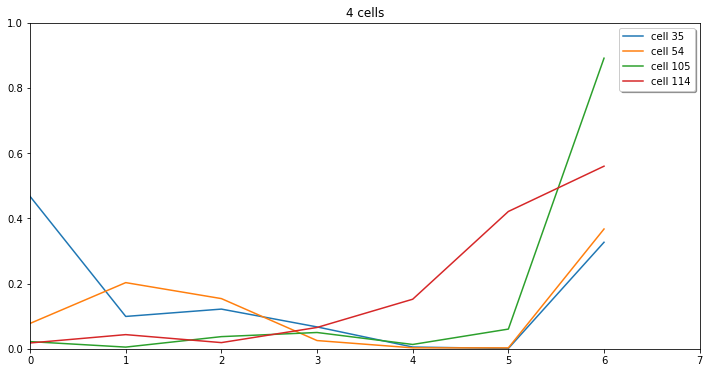

-----------------------------
group 7: [0.04434174 0.25288588 0.21443978 0.39718518 0.43383533 0.65395284
 0.8407216 ]
cells: [17, 76, 98]


-----------------------------
group 8: [0.41556704 0.07292366 0.23727822 0.5160993  0.86108196 0.99649537
 0.9705384 ]
cells: [104]


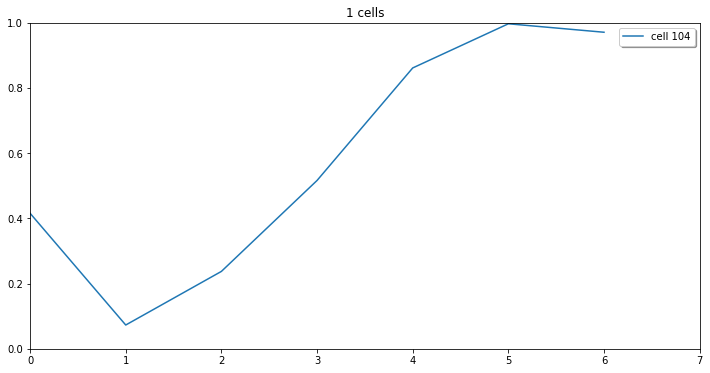

-----------------------------
group 9: [0.9042065  0.8901068  0.93864757 0.9580277  0.9258518  0.8649043
 0.8716307 ]
cells: [4, 30, 38, 43, 51, 62, 66, 70, 122]


-----------------------------
group 10: [0.9998685  0.99987984 0.99979866 0.9995499  0.99414015 0.9380694
 0.09245306]
cells: [9, 16, 24, 44, 49, 58, 78, 87, 95, 103, 106]


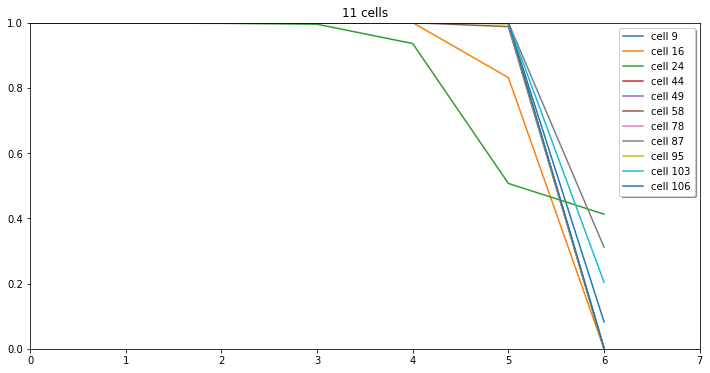

-----------------------------
group 11: [0.9789413  0.97850966 0.98981494 0.9790989  0.82996917 0.08651403
 0.03244792]
cells: [7, 10, 15, 18, 19, 47, 50, 57, 60, 67, 77, 80, 81, 82, 90, 96, 97, 116, 126]


-----------------------------
group 12: [0.96216285 0.9543758  0.9413153  0.84368825 0.2562183  0.01906556
 0.00833826]
cells: [5, 25, 36, 48, 68, 73, 74, 83, 86, 89, 91, 92, 110, 117, 123, 125]


-----------------------------
group 13: [0.61918366 0.92645764 0.2770674  0.5509598  0.825279   0.3623094
 0.03206889]
cells: [32, 100]


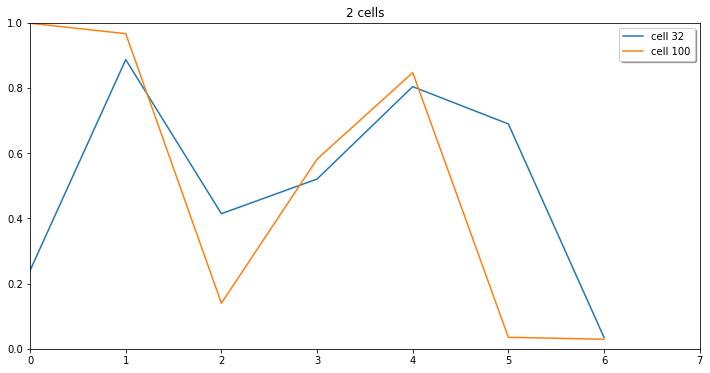

-----------------------------
group 14: [0.01027137 0.92282814 0.96907926 0.9975063  0.9991102  0.9995105
 0.9974094 ]
cells: [1]


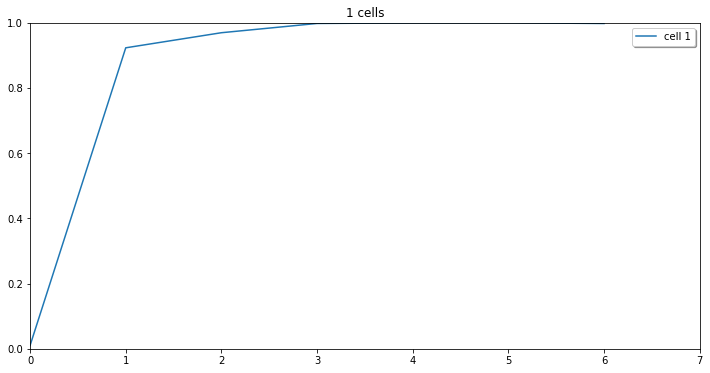

In [42]:
analyze_cells(gates_avg['input'], 15)

average of squared distances of samples to centers: 0.05846800538762739
average of squared distances of centers to centers: 2.2007860456194197
ratio: 37.64086069002681
-----------------------------
group 0: [0.94478667 0.9847671  0.9734011  0.9699029  0.9761908  0.9765422
 0.5403175 ]
cells: [4, 8, 19, 48, 59, 60, 91, 97, 99]


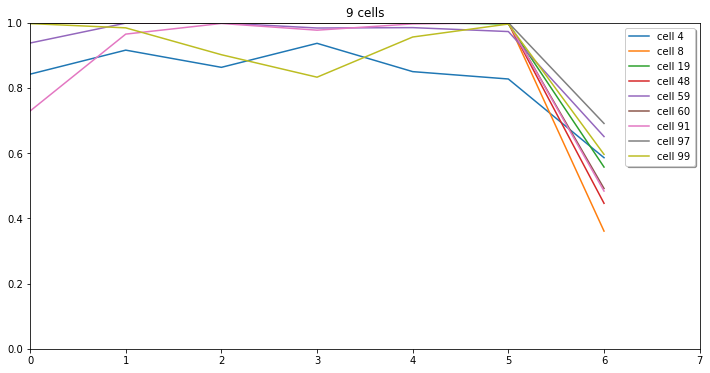

-----------------------------
group 1: [0.96203125 0.9683329  0.9398902  0.9732042  0.9955243  0.99554294
 0.9530239 ]
cells: [6, 15, 25, 26, 28, 33, 34, 35, 46, 50, 67, 85, 86, 106]


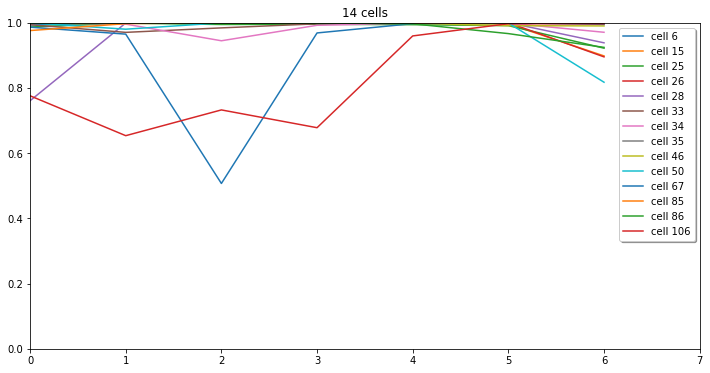

-----------------------------
group 2: [0.47010517 0.9262227  0.9366381  0.8402712  0.80876607 0.90079206
 0.8869176 ]
cells: [9, 22, 30, 37, 39, 53, 64]


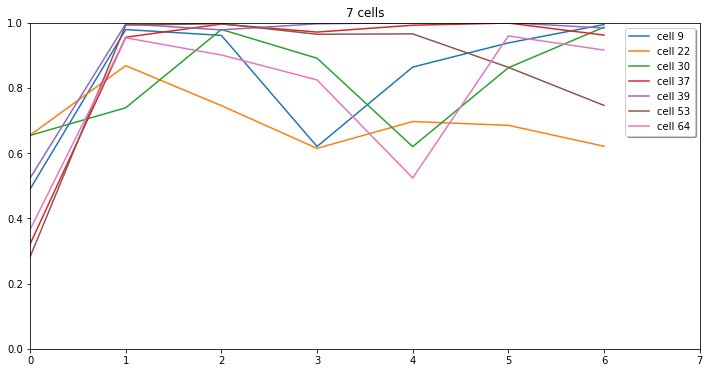

-----------------------------
group 3: [0.23937741 0.56482935 0.7397179  0.883066   0.96621263 0.99594826
 0.989257  ]
cells: [1, 36, 58, 68, 78, 114, 117]


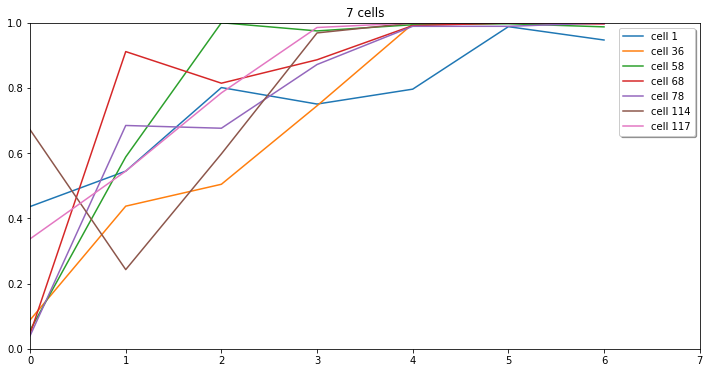

-----------------------------
group 4: [0.03200763 0.10664761 0.6543871  0.68096036 0.81662023 0.7956165
 0.46097627]
cells: [70, 116, 125]


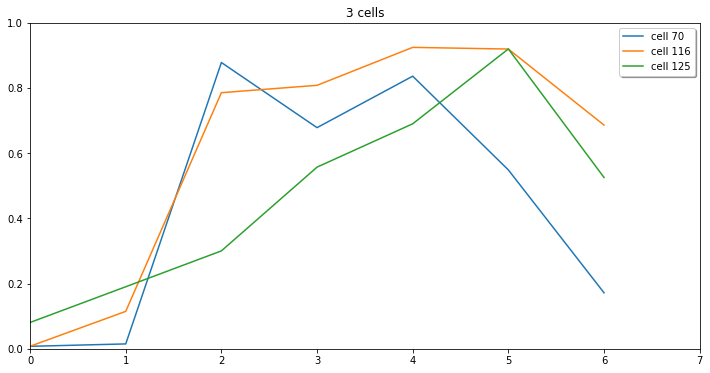

-----------------------------
group 5: [0.06684434 0.08748412 0.07721317 0.19039202 0.7314374  0.988031
 0.9923065 ]
cells: [3, 16, 23, 24, 55, 82, 89, 94, 104, 107]


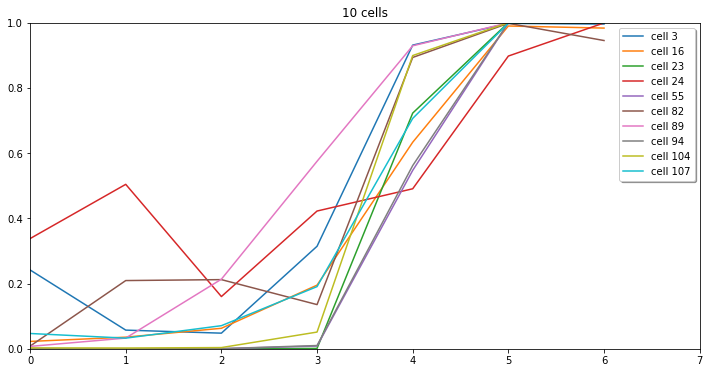

-----------------------------
group 6: [0.74693704 0.03198642 0.06269687 0.25158504 0.8399128  0.99827915
 0.9207033 ]
cells: [31, 98, 105]


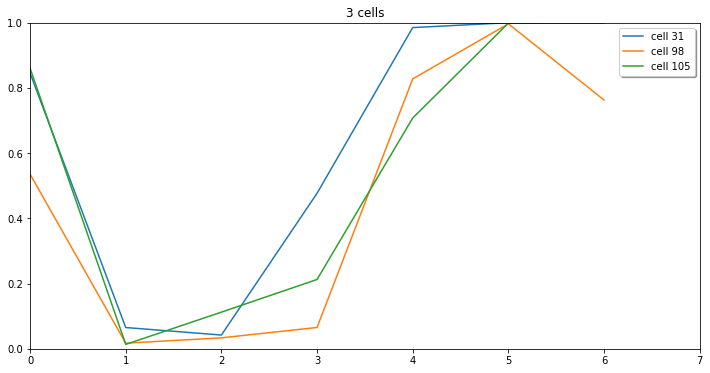

-----------------------------
group 7: [0.7989861  0.13150537 0.01881844 0.01238453 0.12969601 0.942943
 0.99788046]
cells: [32, 61, 69, 71]


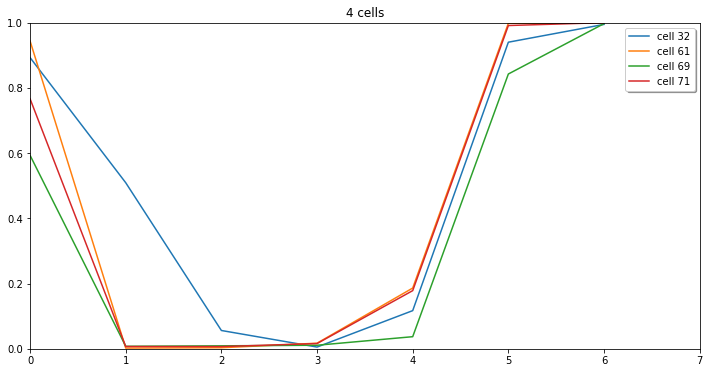

-----------------------------
group 8: [0.04228604 0.06431329 0.02701682 0.01184154 0.04799902 0.7546384
 0.8962885 ]
cells: [7, 54, 72, 75, 101, 103]


-----------------------------
group 9: [0.0606432  0.07063454 0.1096496  0.09575957 0.0871945  0.3437959
 0.22686437]
cells: [66, 76, 108, 122]


-----------------------------
group 10: [0.41582486 0.42506137 0.75341755 0.09523332 0.29160047 0.83122456
 0.8154728 ]
cells: [51, 95, 118]


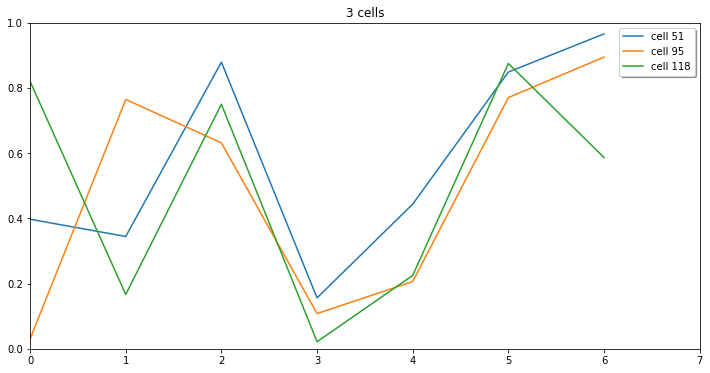

-----------------------------
group 11: [8.7476093e-01 9.0715396e-01 8.2363772e-01 2.2584200e-04 2.1491647e-03
 9.7485846e-01 9.4042540e-01]
cells: [2]


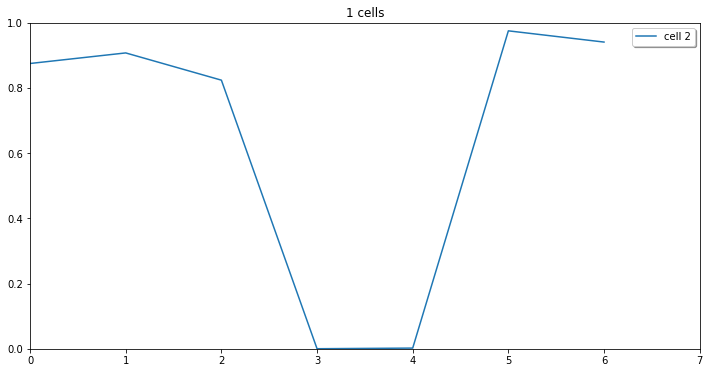

-----------------------------
group 12: [0.9756786  0.96984375 0.22741139 0.0739612  0.02991974 0.22714865
 0.31134593]
cells: [84, 87]


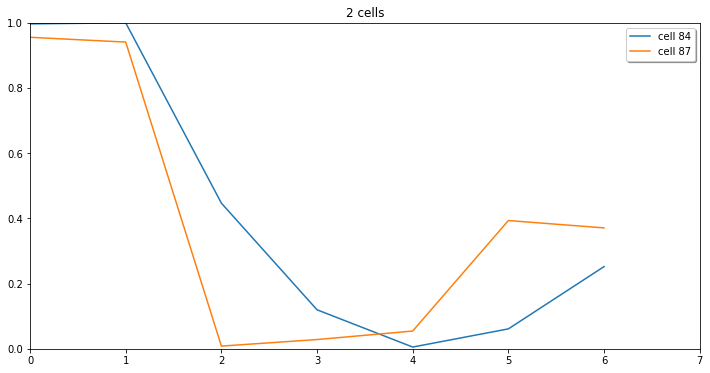

-----------------------------
group 13: [9.9997562e-01 9.9942607e-01 9.9643892e-01 9.7924542e-01 2.0750594e-01
 6.0849190e-03 2.0378828e-04]
cells: [40]


-----------------------------
group 14: [0.98721796 0.9956529  0.99904335 0.99289393 0.9881139  0.9745128
 0.05276075]
cells: [0, 5, 10, 11, 12, 13, 14, 17, 18, 20, 21, 27, 29, 38, 41, 42, 43, 44, 45, 47, 49, 52, 56, 57, 62, 63, 65, 73, 74, 77, 79, 80, 81, 83, 88, 90, 92, 93, 96, 100, 102, 109, 110, 111, 112, 113, 115, 119, 120, 121, 123, 124, 126, 127]


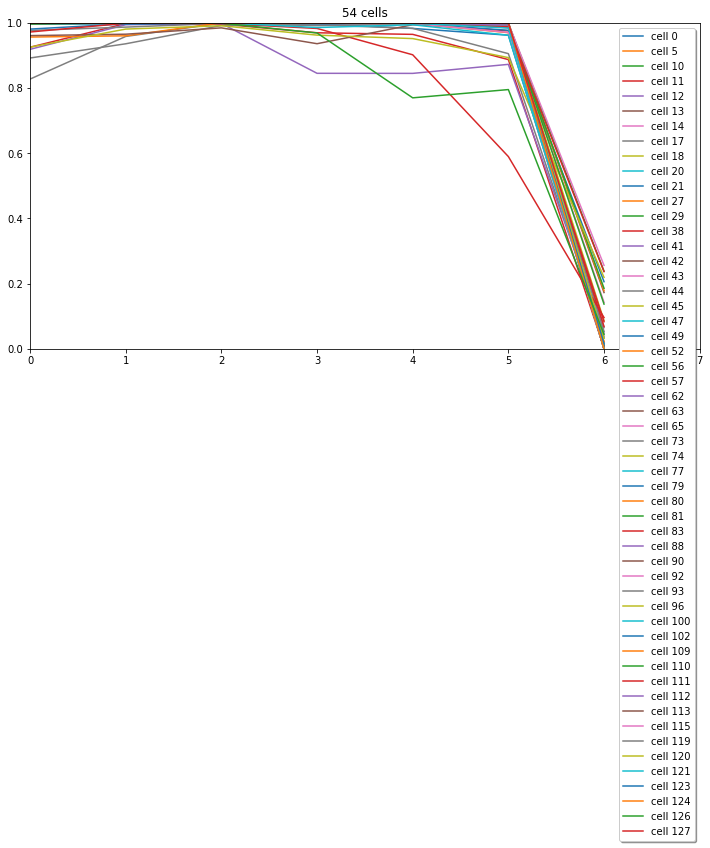

In [43]:
analyze_cells(gates_avg['reset'], 15)

average of squared distances of samples to centers: 0.6386113092219294
average of squared distances of centers to centers: 7.945573497953869
ratio: 12.441955510676108
-----------------------------
group 0: [-0.9673009  -0.99999577 -0.9999944  -0.9933585  -0.9739164  -0.96863717
  0.91067994]
cells: [18, 19, 34, 35, 37, 64, 99]


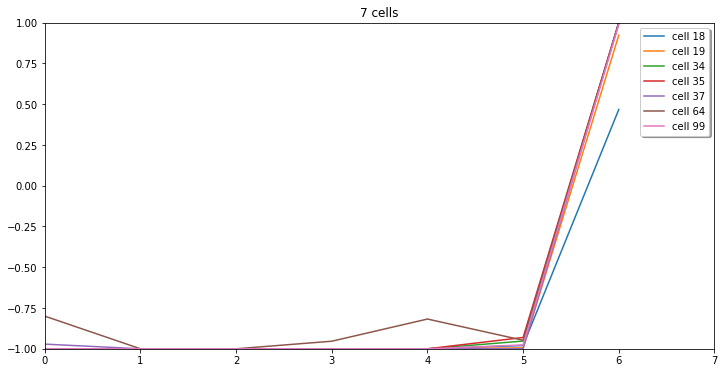

-----------------------------
group 1: [-0.9955728  -0.98114145 -0.88178307 -0.97999704 -0.96963525 -0.924098
 -0.19873561]
cells: [25, 26, 27, 30, 45, 47, 48, 65, 74, 81, 83, 100, 109, 111, 115, 119, 120]


-----------------------------
group 2: [ 0.24841455 -0.59550536 -0.88667715 -0.93856597 -0.9598105  -0.9459329
 -0.54082286]
cells: [89, 93, 110, 116, 117, 126]


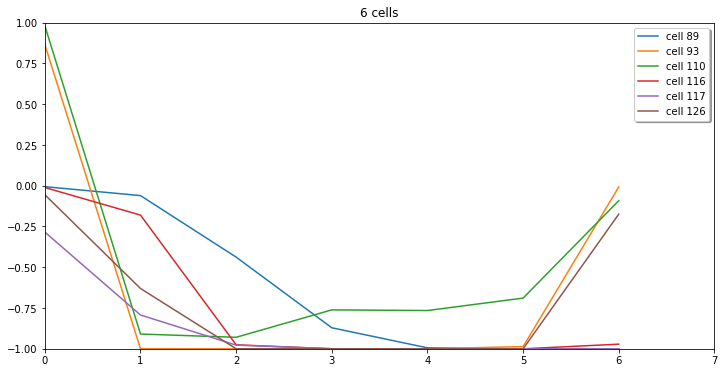

-----------------------------
group 3: [ 0.13740468  0.19791652  0.0586796  -0.03798929 -0.32223514 -0.9177665
 -0.8389507 ]
cells: [3, 54, 55, 66, 72, 80, 86, 94, 95, 104, 107]


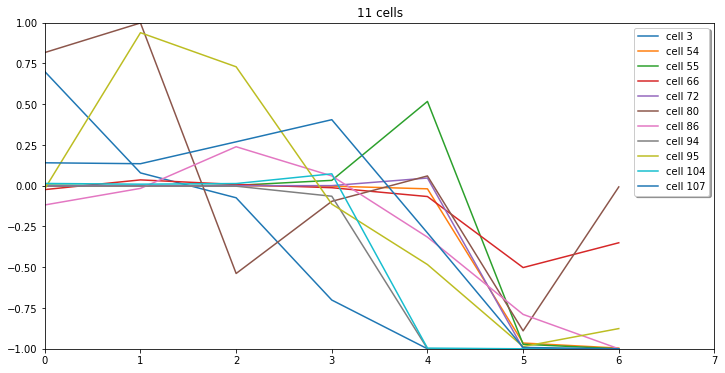

-----------------------------
group 4: [ 0.8495611   0.97335625  0.9317227   0.66179335 -0.8599019  -0.9836765
 -0.8189555 ]
cells: [10, 43, 60, 78, 91, 114]


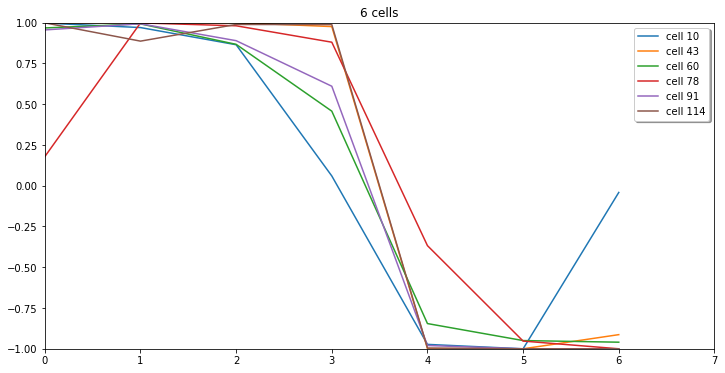

-----------------------------
group 5: [ 0.9167982   0.99999166  0.99981505  0.9972177   0.84358644 -0.9628384
 -0.35168704]
cells: [11, 14, 33, 63, 67, 68, 88, 113, 124]


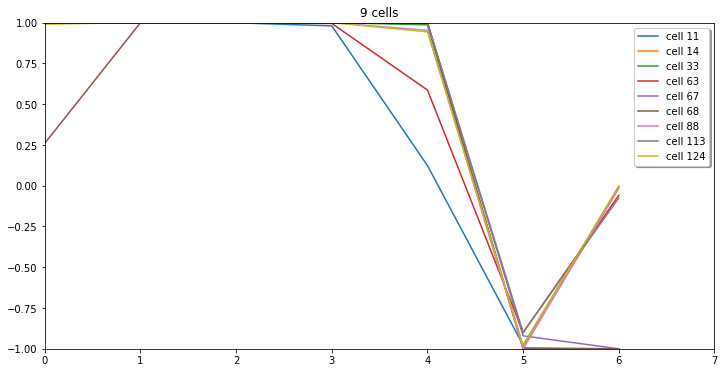

-----------------------------
group 6: [ 0.8523571   0.97002447  0.95395595  0.9825942   0.99658096  0.90343845
 -0.04285551]
cells: [4, 5, 6, 8, 21, 36, 39, 42, 46, 50, 52, 53, 57, 58, 59, 62, 73, 77, 90, 121, 125]


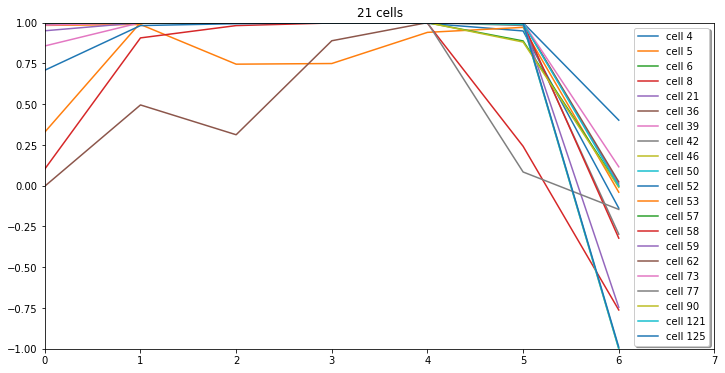

-----------------------------
group 7: [ 0.18652433 -0.1581715   0.14846352  0.04918987  0.2702576   0.711868
 -0.06045726]
cells: [2, 23, 32, 70, 71, 87, 96, 101, 108, 122]


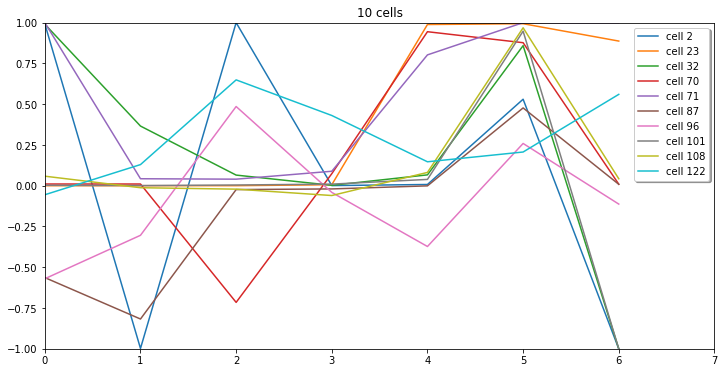

-----------------------------
group 8: [-0.472542   -0.3471911  -0.17597756 -0.26088852 -0.18548769  0.87371945
  0.97380507]
cells: [7, 16, 24, 31, 61, 75, 76, 103]


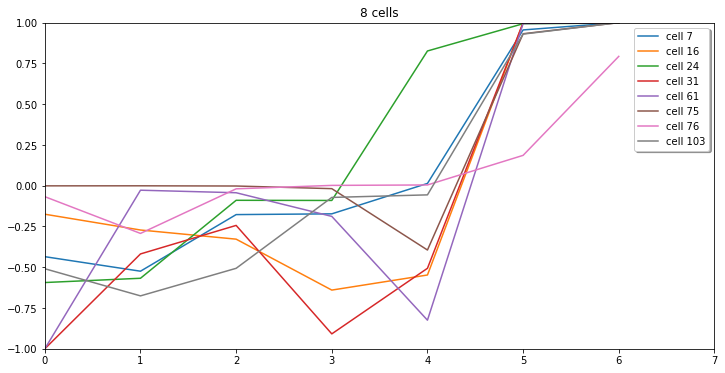

-----------------------------
group 9: [-0.9197319  -0.89245164 -0.8303723  -0.5434791   0.2329937   0.7299117
 -0.15918079]
cells: [17, 49, 51, 79, 106]


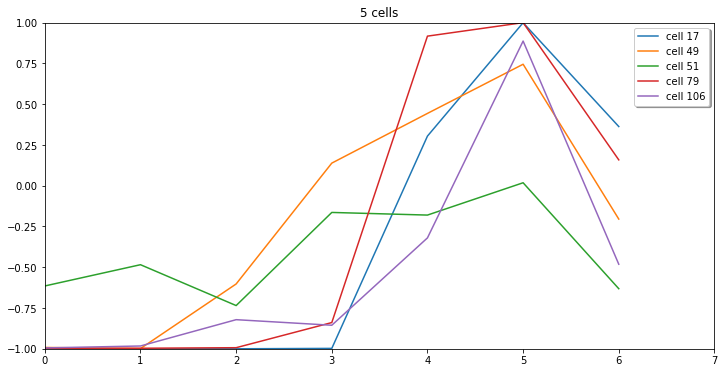

-----------------------------
group 10: [-0.9062485  -0.99710995 -0.9958185  -0.98031056 -0.9031008   0.9648122
  0.52252305]
cells: [0, 20, 22, 28, 41, 56, 82, 85, 92, 97, 102, 123]


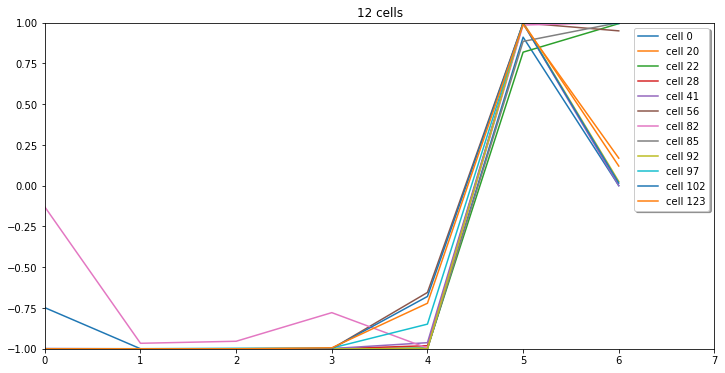

-----------------------------
group 11: [ 0.9921314  -0.08875528 -0.5958704  -0.6215614  -0.7988902   0.37504664
  0.74362075]
cells: [9, 13, 98, 105]


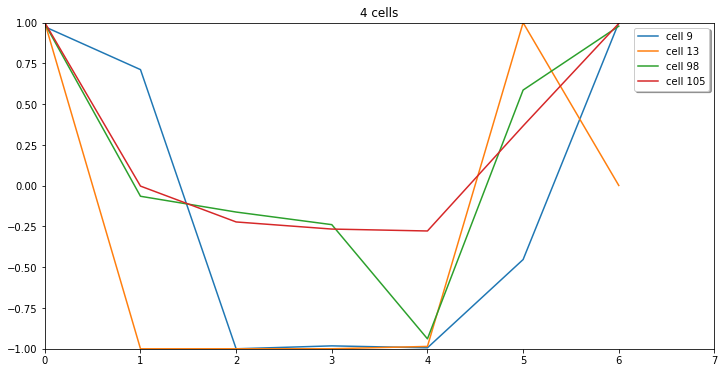

-----------------------------
group 12: [-0.5789065  -0.03463293  0.19966714 -0.22334145 -0.23517476 -0.6638132
  0.79680496]
cells: [1, 15, 69, 118]


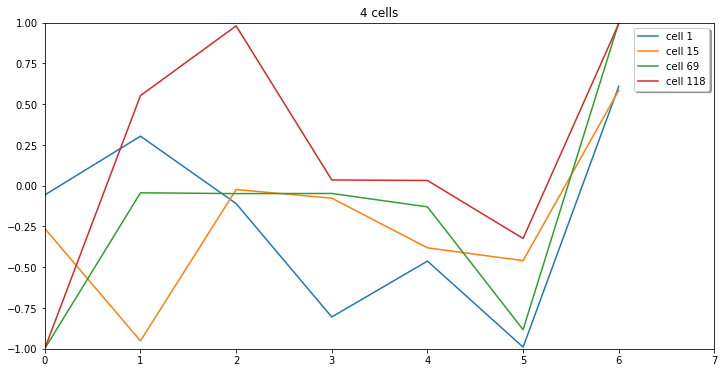

-----------------------------
group 13: [-0.88663936  0.95364106 -0.98417753 -0.8947124  -0.72379905 -0.37162417
 -0.00995312]
cells: [29, 44, 84, 112]


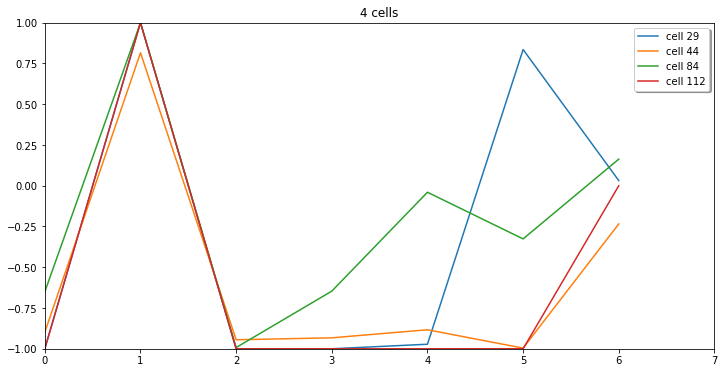

-----------------------------
group 14: [-0.8862656  -0.49955297  0.93230563  0.9750634   0.6904027  -0.03171921
 -0.16826718]
cells: [12, 38, 40, 127]


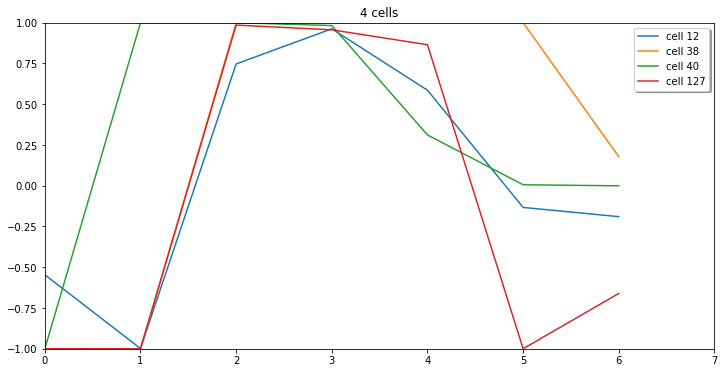

In [44]:
analyze_cells(gates_avg['new'], 15, ylim=(-1,1))

average of squared distances of samples to centers: 0.727023445148161
average of squared distances of centers to centers: 7.625635928199404
ratio: 10.4888445882861
-----------------------------
group 0: [ 0.8702921   0.78364193  0.7155695   0.54570395 -0.29562572 -0.8923228
 -0.53846544]
cells: [60, 74, 83, 91, 110, 114, 116, 126]


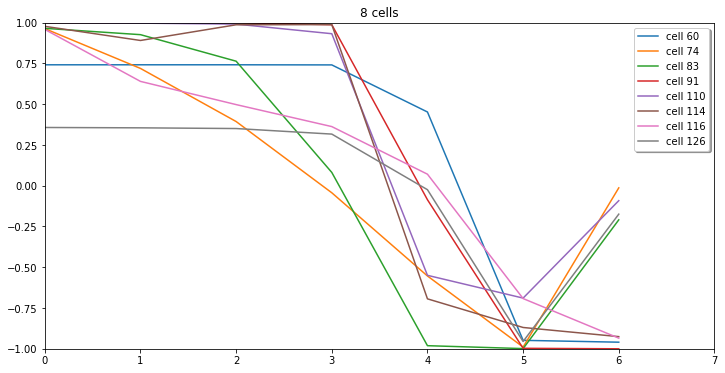

-----------------------------
group 1: [ 0.85890245  0.9808973   0.9808422   0.97810274  0.7611702  -0.90961534
  0.04641872]
cells: [11, 14, 18, 63, 88, 113]


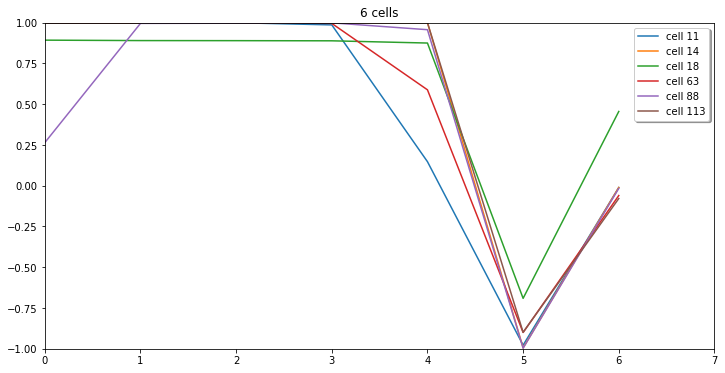

-----------------------------
group 2: [ 0.7477957   0.48571235  0.6612714   0.5316094   0.5245382   0.5131679
 -0.5372198 ]
cells: [2, 8, 32, 44, 51, 66, 78, 95, 106]


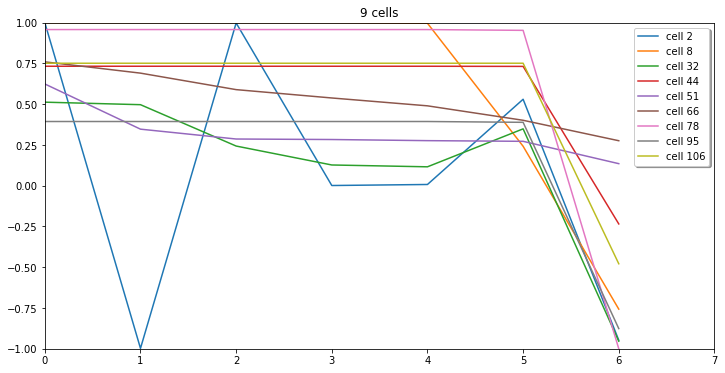

-----------------------------
group 3: [0.9607659  0.9589076  0.9578745  0.957544   0.9475086  0.92904705
 0.48890516]
cells: [16, 43, 52, 70, 87, 90, 121]


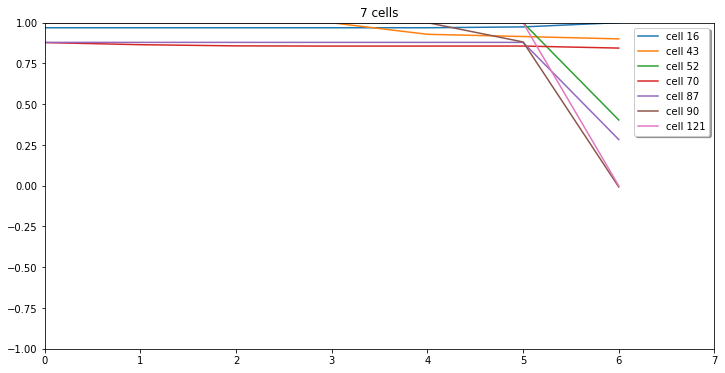

-----------------------------
group 4: [-0.9945621   0.90475655  0.98705643  0.8029732   0.6577134   0.13849545
  0.14187577]
cells: [21, 40, 42, 118, 124]


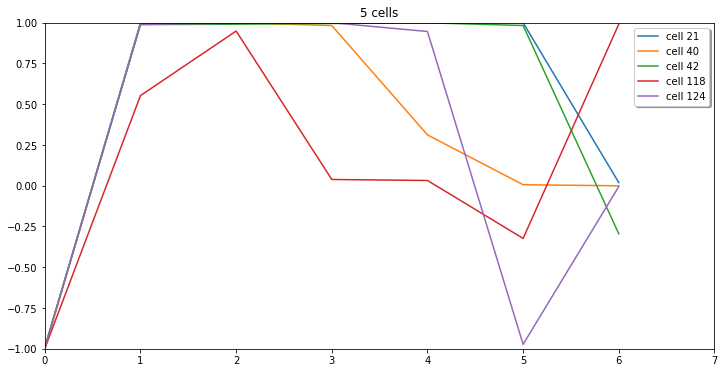

-----------------------------
group 5: [ 0.07762589 -0.01382172 -0.04409092 -0.10611159 -0.15525913  0.3334435
  0.39216867]
cells: [1, 4, 19, 24, 28, 30, 57, 62, 69, 75, 76, 77, 96, 97, 104, 105, 108, 123]


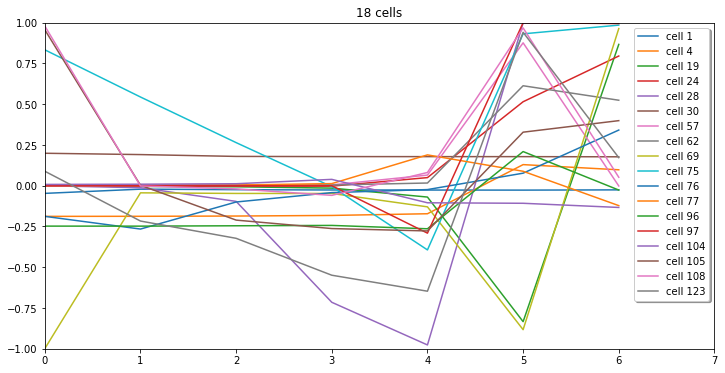

-----------------------------
group 6: [-0.28569517 -0.32715023 -0.06550629  0.45550603  0.95510626  0.99889565
  0.98133695]
cells: [6, 23, 36, 39, 53, 71]


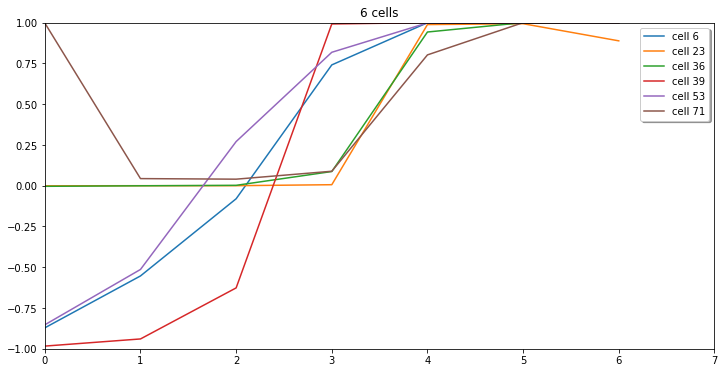

-----------------------------
group 7: [-0.97862655 -0.9154025  -0.7174203  -0.49112713  0.5152347   0.7854574
  0.11914557]
cells: [5, 38, 73, 79]


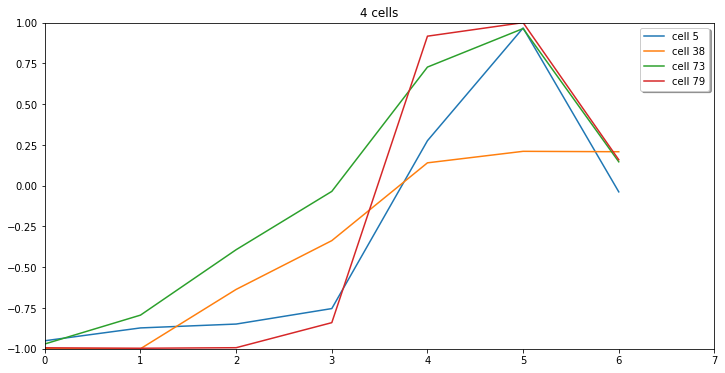

-----------------------------
group 8: [-0.47238368 -0.57075614 -0.28718463  0.37038603  0.492567    0.7787053
 -0.79383624]
cells: [12, 46, 50, 59, 101, 125]


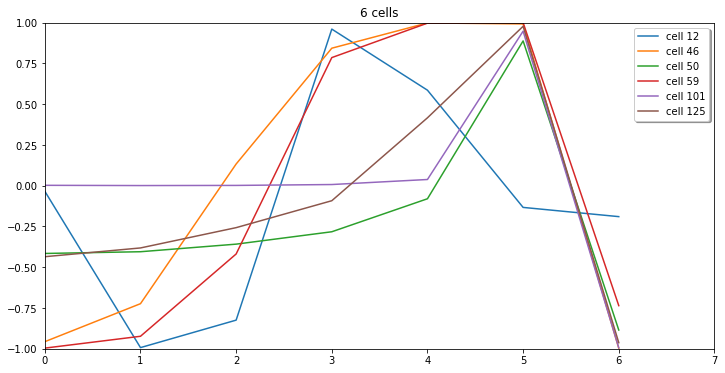

-----------------------------
group 9: [-0.1715073  -0.25797817  0.16444208  0.24099013  0.34193438 -0.976767
 -0.86400634]
cells: [33, 54, 55, 67, 68, 72, 100, 107, 127]


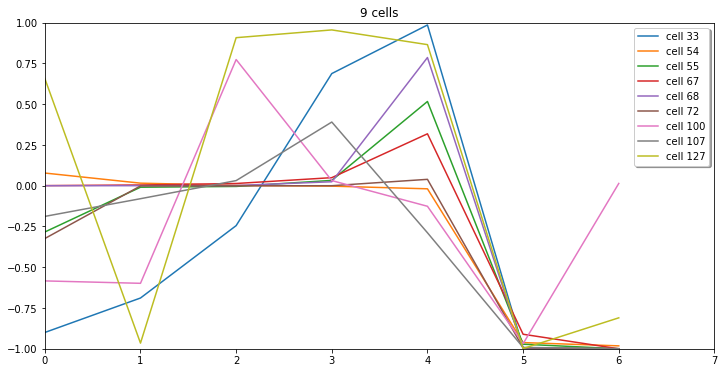

-----------------------------
group 10: [ 0.34940594 -0.18115756 -0.23406203 -0.4059978  -0.8464687  -0.9670546
 -0.6091798 ]
cells: [3, 10, 25, 45, 89, 93, 94, 98, 117, 120]


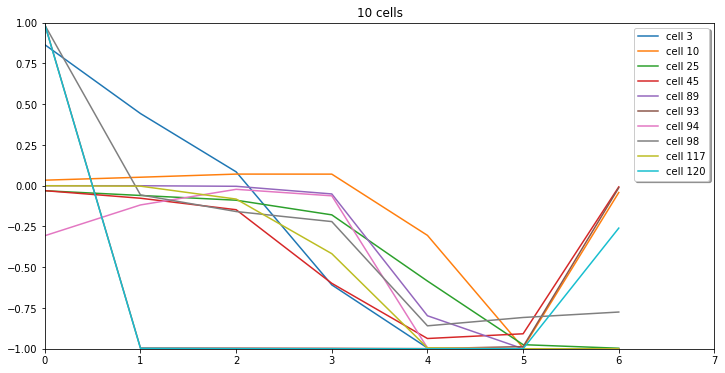

-----------------------------
group 11: [-0.9154284  -0.83200526 -0.90756816 -0.9121785  -0.8828134  -0.8441502
  0.07129637]
cells: [9, 15, 26, 27, 34, 35, 37, 47, 48, 49, 58, 65, 80, 81, 86, 99, 103, 109, 111, 112, 115, 119, 122]


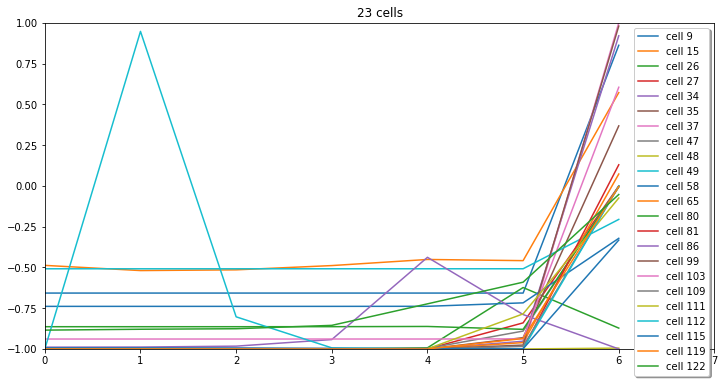

-----------------------------
group 12: [-0.9990279  -0.7256152  -0.8687947  -0.9206497  -0.87063646  0.8638494
  0.5821288 ]
cells: [0, 7, 17, 20, 22, 29, 31, 41, 56, 61, 82, 85, 92]


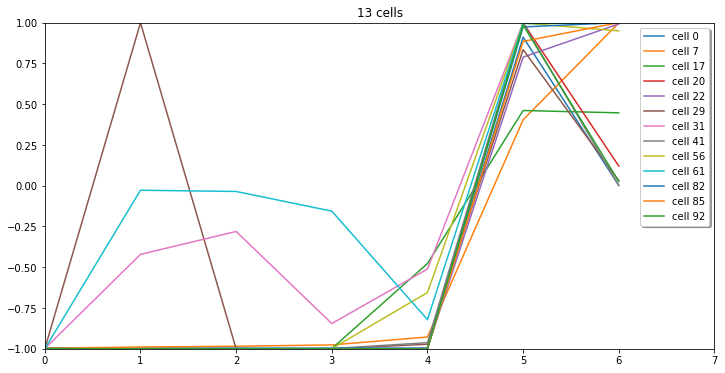

-----------------------------
group 13: [ 0.9954545  -0.99887806 -0.99978954 -0.99920404 -0.83229935  0.9977819
  0.00920546]
cells: [13, 102]


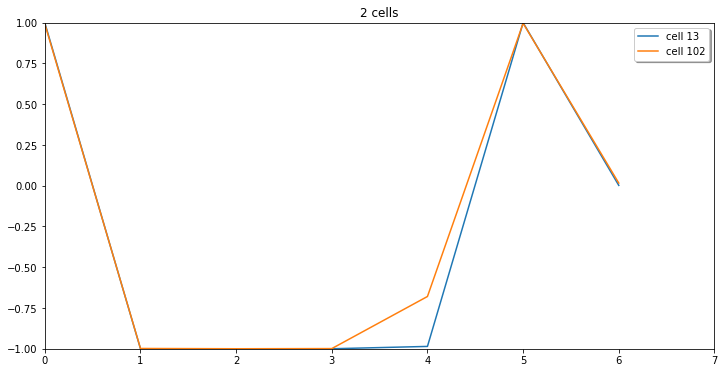

-----------------------------
group 14: [ 0.9926459   0.9961393  -0.9957544  -0.8070254  -0.43336353 -0.63108575
  0.34181446]
cells: [64, 84]


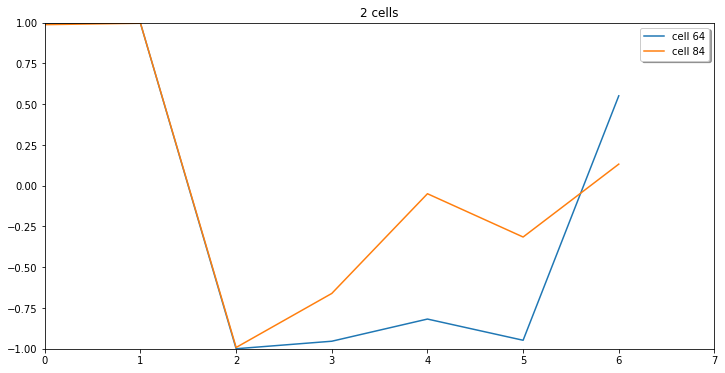

In [45]:
analyze_cells(gates_avg['hidden'], 15, ylim=(-1,1))

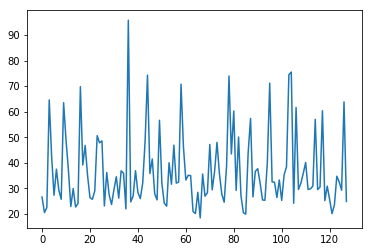

In [46]:
a = np.sum(np.abs(W), axis=0)
plt.plot(a)

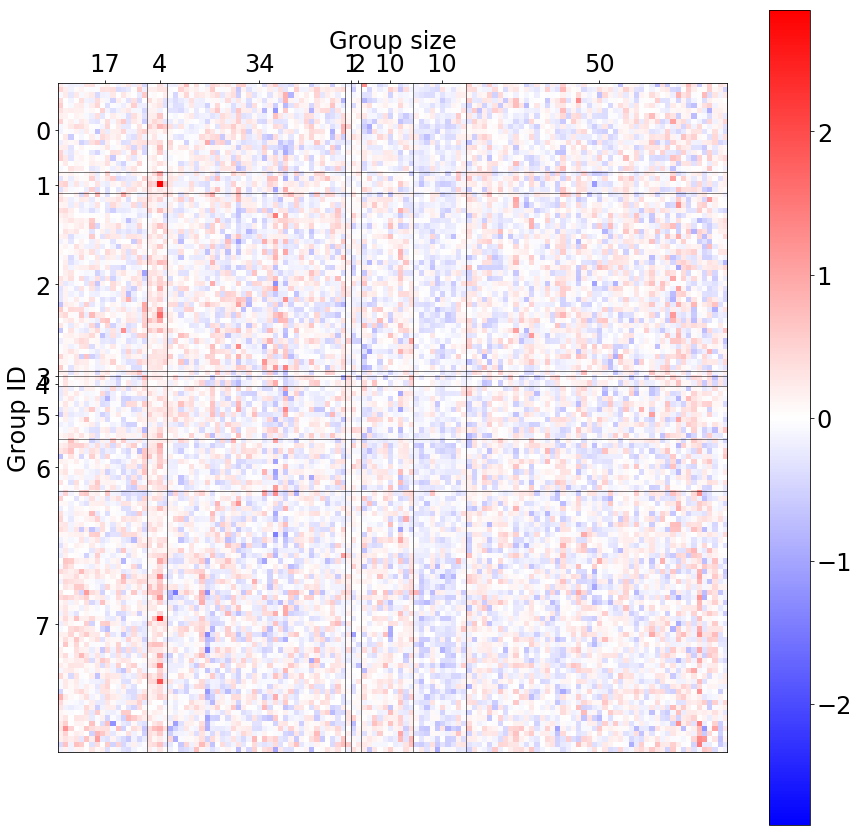

In [47]:
W = model.decoder.clf.weight.detach().numpy()
plot_weights(W[512:640,:], groups)